In [1]:
import pandas as pd
import numpy as np
import scipy
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In C:\applications\anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\applications\anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\applications\anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\applications\anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\applications\anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

In [2]:
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.inspection import permutation_importance

In [3]:
from rdkit import Chem
from rdkit.Chem import AllChem
from IPython.display import SVG
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from utility import depictBit,Kfold

In [4]:
#=================run below codes to preprocess data=========================

In [5]:
print('reading data')
data = pd.read_csv('rcf_lipid_combined.csv',encoding='cp1252')
print('reading data finished')

reading data
reading data finished


In [6]:
SMILES = data['SMILES'].to_numpy()
MW = data['MW'].to_numpy().reshape(-1,1)
logKOW = data['log Kow'].to_numpy().reshape(-1,1)
OM = data['fom (%)'].to_numpy().reshape(-1,1)
flipid = data['flip (%)'].to_numpy().reshape(-1,1)

RCF_soil = data['log RCF-soil'].to_numpy()

#generate ECFP for all molecules
print('statr generating ECFP')
FP = []

for i,sm in enumerate(SMILES):
    mol = Chem.MolFromSmiles(sm)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024)
    FP.append(fp)
FP = np.array(FP)
print('finish generating ECFP')

n_sample = len(RCF_soil)

print('start 5-fold cross-validation for GBRT-ECFP model')
feature_w_smiles = np.concatenate((FP,OM,flipid),1)
feature_w_smiles_z = scipy.stats.mstats.zscore(feature_w_smiles,0)
feature_w_smiles_z[np.isnan(feature_w_smiles_z)] = 0
total_id = np.load('sample_index.npy')

statr generating ECFP
finish generating ECFP
start 5-fold cross-validation for GBRT-ECFP model


In [7]:
train_split_index,test_split_index = Kfold(n_sample,5)

splits = 5
prediction_w_smiles = []
prediction_true_w_smiles = []
test_score_all_w_smiles = []
feature_importance_all_w_smiles = []

importance_all_dots_w_smiles_test = []
permute_importance_all_w_smiles_test = []

importance_all_dots_w_smiles_train = []
permute_importance_all_w_smiles_train = []

for k in range(splits):
    
    print('batch is ',k)
    train_index = train_split_index[k][:int(len(train_split_index[k])*0.875)]
    valid_index = train_split_index[k][int(len(train_split_index[k])*0.875):]
    test_index = test_split_index[k]
    
    train_id = [total_id[i] for i in train_index]
    valid_id = [total_id[i] for i in valid_index]
    test_id = [total_id[i] for i in test_index]
    
    train_feature = [feature_w_smiles_z[i] for i in train_id]
    train_label = [RCF_soil[i] for i in train_id]
    
    valid_feature = [feature_w_smiles_z[i] for i in valid_id]
    valid_label = [RCF_soil[i] for i in valid_id]
    
    test_feature = [feature_w_smiles_z[i] for i in test_id]
    test_label = [RCF_soil[i] for i in test_id]
    
    n_estimator = [200,250,500,750,1000,1250]
    max_depths = [2,4,6,8,10]
    
    best_valid_score = 0
    for ne in n_estimator:
        for m_d in max_depths:
            model = GradientBoostingRegressor(n_estimators=ne,max_depth=m_d)
            model.fit(np.array(train_feature),np.array(train_label).reshape(-1))
            valid_score = model.score(valid_feature,np.array(valid_label).reshape(-1,1))
            if valid_score>best_valid_score:
                best_valid_score = valid_score
                test_score = model.score(test_feature,np.array(test_label).reshape(-1,1))                
                pred = model.predict(test_feature)
                best_n = ne
                best_d = m_d
    
    model = GradientBoostingRegressor(n_estimators=best_n,max_depth=best_d).fit(np.array(train_feature),np.array(train_label))
    
    permut_importance_test = permutation_importance(model,test_feature,np.array(test_label),n_repeats=10)
    importance_all_dots_w_smiles_test.append(permut_importance_test.importances)
    
    #plot_partial_dependence(model, np.array(train_feature)[:,-2].reshape(-1,1),['OM'],np.array(['OM']))
    #plot_partial_dependence(model, np.array(train_feature)[:,-1].reshape(-1,1),['flipid'],np.array(['flipid']))
    
    #permut_importance_train = permutation_importance(model,np.array(train_feature),np.array(train_label),n_repeats=10)
    #importance_all_dots_w_smiles_train.append(permut_importance_train.importances)
    
    print(test_score)
    prediction_w_smiles.append(pred)
    prediction_true_w_smiles.append(test_label)
    test_score_all_w_smiles.append(test_score)
    feature_importance_all_w_smiles.append(model.feature_importances_)
    
    permute_importance_all_w_smiles_test.append(permut_importance_test.importances_mean)
    #permute_importance_all_w_smiles_train.append(permut_importance_train.importances_mean)
    print('best n_estimator is',best_n)
    print('best depth is',best_d)
    print('feature importance',model.feature_importances_)

batch is  0
0.6943699832666388
best n_estimator is 200
best depth is 6
feature importance [1.51165998e-05 1.57941914e-03 0.00000000e+00 ... 0.00000000e+00
 2.63700833e-01 1.85697718e-01]
batch is  1
0.702709976536811
best n_estimator is 250
best depth is 4
feature importance [5.28149777e-05 9.33517550e-03 0.00000000e+00 ... 0.00000000e+00
 2.63350464e-01 2.74578781e-01]
batch is  2
0.8343000451263373
best n_estimator is 500
best depth is 2
feature importance [4.93547597e-06 1.66096422e-03 0.00000000e+00 ... 0.00000000e+00
 2.48796915e-01 1.78923263e-01]
batch is  3
0.8432238229601449
best n_estimator is 1000
best depth is 2
feature importance [4.61240796e-06 3.92312329e-05 0.00000000e+00 ... 0.00000000e+00
 2.70695134e-01 2.18518349e-01]
batch is  4
0.7608093446757063
best n_estimator is 1000
best depth is 2
feature importance [7.23810899e-06 7.93578714e-04 2.95858344e-05 ... 0.00000000e+00
 2.66418048e-01 1.54346307e-01]


In [8]:
#example of generating substructures from permutation importance

In [9]:
mean_feature_importance_all_permute_smiles_test = np.mean(permute_importance_all_w_smiles_test,0)

In [10]:
sorted_feature_imporatnce_idx_permute_smiles_test = np.argsort(mean_feature_importance_all_permute_smiles_test[:-2])[::-1]

In [11]:
#There could be slightly difference due to random shuffle and/or package versions
top_10_permute = sorted_feature_imporatnce_idx_permute_smiles_test[:10]
print('The top 10 most important substructure id from permutation importance is',top_10_permute)

The top 10 most important substructure id from permutation importance is [875 561 695 333 888 326 530 320 201 455]


In [12]:
#select a substructure id and visualize it
struture_id = 888

In [13]:
#run through all chemicals and print all chemicals that contain this substructure
for i,sm in enumerate(SMILES):
    info = {}
    mol = Chem.MolFromSmiles(sm)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024,bitInfo=info)
    if struture_id in info:
        print(i)

39
232
233
234
235
236
243
244
245
246
247
261
264
266


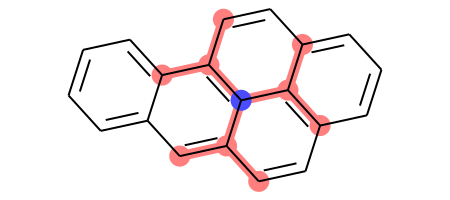

In [14]:
#select one molecule from above and visualize the important substructure
sm = SMILES[39]
mol = Chem.MolFromSmiles(sm)
depictBit(struture_id,mol)